#### Második házi feladat
#### Gárdi Réka Lorin (ZRAF2X)
###### 2026. 03. 28.

In [1]:
# library-k betöltése
import numpy as np
from scipy.optimize import minimize
from collections.abc import Callable
import matplotlib.pyplot as plt

#### Órai kódok betöltése

In [2]:
def european_call_payoff(S: float, K: float) -> float:
    return max(S-K, 0.0)

In [3]:
def create_spot_tree(spot: float, spot_mult_up: float, spot_mult_down: float, steps: int) -> list[list[float]]:
    previous_level = [spot]
    tree = [previous_level]
    for _ in range(steps):
        new_level = [s * spot_mult_down for s in previous_level]
        new_level += [previous_level[-1] * spot_mult_up]
        tree += [new_level]
        previous_level = new_level
    return tree

In [4]:
def create_discounted_price_tree(spot_tree: list[list[float]], discount_factor: float, K: float, diag: int = 0) -> list[list[float]]:
    spot = spot_tree[0][0]
    spot_mult_up = spot_tree[1][-1]
    spot_mult_down = spot_tree[1][0]
    p_up = ((1 / discount_factor - spot_mult_down) /
                   (spot_mult_up - spot_mult_down))
    p_down = 1 - p_up
    steps = len(spot_tree) - 1
    continuation_value_tree = [[np.nan for _ in level] for level in spot_tree]
    if diag > 0:
        print("risk-neutral measure: ")
        print(('%.3f' % p_up, '%.3f' % p_down))
        # init delta tree
        delta_tree = [[np.nan for _ in level] for level in spot_tree[:-1]] #delta makes no sense for leaves
    # going backwards, payoff is known in leaves
    for i in range(len(spot_tree[-1])):
        spot = spot_tree[-1][i]
        discounted_continuation_value = discount_factor**(steps) * european_call_payoff(spot, K)
        continuation_value_tree[-1][i] = discounted_continuation_value
    for step in range(steps - 1, -1, -1):
        for i in range(len(spot_tree[step])):
            continuation_value_tree[step][i] = p_up * continuation_value_tree[step + 1][i] + \
                                            p_down * continuation_value_tree[step + 1][i + 1]
            if diag > 0:
                delta_tree[step][i] = ((continuation_value_tree[step + 1][i] - continuation_value_tree[step + 1][i + 1]) 
                                       / (spot_tree[step + 1][i] - spot_tree[step + 1][i + 1]))
    if diag > 0:
        print("delta: ")
        delta_tree_readable = [['%.3f' % e for e in n] for n in delta_tree]
        print(delta_tree_readable)
    return continuation_value_tree

In [5]:
def calcBalancedDownStep(spot_mult_up: float, discount_factor: float) -> (float, float):
    return spot_mult_up - 2 * (spot_mult_up - 1 / discount_factor)

#### Házi feladat megoldás

In [6]:
def multistart_minimize(h, n_trials=100, bounds=(1.0000001, 100)):
    best = None
    for _ in range(n_trials):
        x0 = np.random.uniform(bounds[0], bounds[1])  # Kezdőpont véletlenszerűen a bound-okból
        now = minimize(h, x0=x0, bounds=[bounds])
        if now.success and (best is None or best.fun > now.fun):
            best = now
    return best

# a sima minimize függvény erősen függ a kezdeti érték megválasztásától, emiatt gyakran nem is sikerült minimumra jutnia
# ezért használom ezt a megoldást, hogy több kezdeti értéket is kipróbálok, és így keresem a minimumot
#forrás: https://math.stackexchange.com/questions/2268335/whats-a-good-way-to-provide-an-initial-guess-to-minimize-sinx-e-cosx2

In [7]:
def calibrate_tree(spot: int, K: int, disc_factor: int, maturity: float, steps_per_year: int, market_price: int):
    steps = steps_per_year * maturity
    discount_factor = disc_factor ** (1/steps_per_year)
    
    def objective(spot_mult_up):
        spot_mult_down = calcBalancedDownStep(spot_mult_up, discount_factor)
        spot_tree = create_spot_tree(spot, spot_mult_up, spot_mult_down, steps)
        price_tree = create_discounted_price_tree(spot_tree, discount_factor, K)
        model_price = price_tree[0][0]
        return (model_price - market_price) ** 2 # négyzetes hibát minimalizálunk
    
    res = multistart_minimize(objective)

    if res.success:
        spot_mult_up = res.x[0]
        spot_mult_down = calcBalancedDownStep(spot_mult_up, discount_factor)
        spot_tree = create_spot_tree(spot, spot_mult_up, spot_mult_down, steps)
        price_tree = create_discounted_price_tree(spot_tree, discount_factor, K)
        final_model_price = price_tree[0][0]
        error = (final_model_price - market_price) ** 2
        
        print("Optimal Spot Multiplier Up:", spot_mult_up)
        print("Spot Multiplier Down:", spot_mult_down)
        print("Final Model Price:", final_model_price)
        print("Squared Error:", error)
        
        return spot_mult_up, spot_mult_down, final_model_price, error
    else:
        print("Optimization failed.")
        return None, None, None, None



##### Same contract with a few different number of steps

In [8]:
np.random.seed(17)

# paraméterek
spot = 1  # fix érték
K = 1.125
disc_factor = 0.85
market_price = 1.2
maturity = 1
steps_per_year_sizes = range(1, 11)

spot_mult_up_values = []
spot_mult_down_values = []
model_prices = []
errors = []

for steps in steps_per_year_sizes:
    result = calibrate_tree(spot, K, disc_factor, maturity, steps, market_price)
    if result[0] is not None:
        spot_mult_up_values.append(result[0])
        spot_mult_down_values.append(result[1])
        model_prices.append(result[2])
        errors.append(result[3])
    else:
        spot_mult_up_values.append(np.nan)
        spot_mult_down_values.append(np.nan)
        model_prices.append(np.nan)
        errors.append(np.nan)


Optimal Spot Multiplier Up: 3.9485294067773786
Spot Multiplier Down: -1.5955882303067899
Final Model Price: 1.199999997880386
Squared Error: 4.492763677893721e-18
Optimal Spot Multiplier Up: 2.602317964101326
Spot Multiplier Down: -0.43301338591476446
Final Model Price: 1.1999999920854503
Squared Error: 6.264009667355441e-17
Optimal Spot Multiplier Up: 2.315778121022378
Spot Multiplier Down: -0.2044437370663763
Final Model Price: 1.2000002985971443
Squared Error: 8.916025461018834e-14
Optimal Spot Multiplier Up: 1.0000001
Spot Multiplier Down: 1.0829327256986885
Final Model Price: 0.05932983050205717
Squared Error: 1.3011284355824657
Optimal Spot Multiplier Up: 2.1533714763059115
Spot Multiplier Down: -0.08729586807804735
Final Model Price: 1.1999999869247404
Squared Error: 1.7096241208413707e-16
Optimal Spot Multiplier Up: 2.1226874990653237
Spot Multiplier Down: -0.0677741753672163
Final Model Price: 1.1999999773114614
Squared Error: 5.147697839594496e-16
Optimal Spot Multiplier Up: 

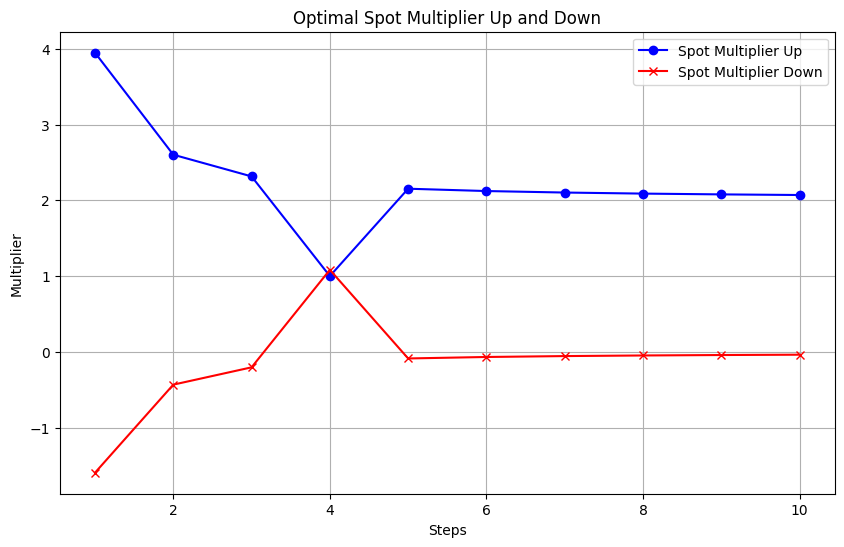

In [9]:
#1. ábra: spot multiplier up és down
plt.figure(figsize=(10, 6))
plt.plot(steps_per_year_sizes, spot_mult_up_values, label="Spot Multiplier Up", color='b', marker='o')
plt.plot(steps_per_year_sizes, spot_mult_down_values, label="Spot Multiplier Down", color='r', marker='x')
plt.xlabel("Steps")
plt.ylabel("Multiplier")
plt.title("Optimal Spot Multiplier Up and Down")
plt.legend()
plt.grid(True)
plt.show()

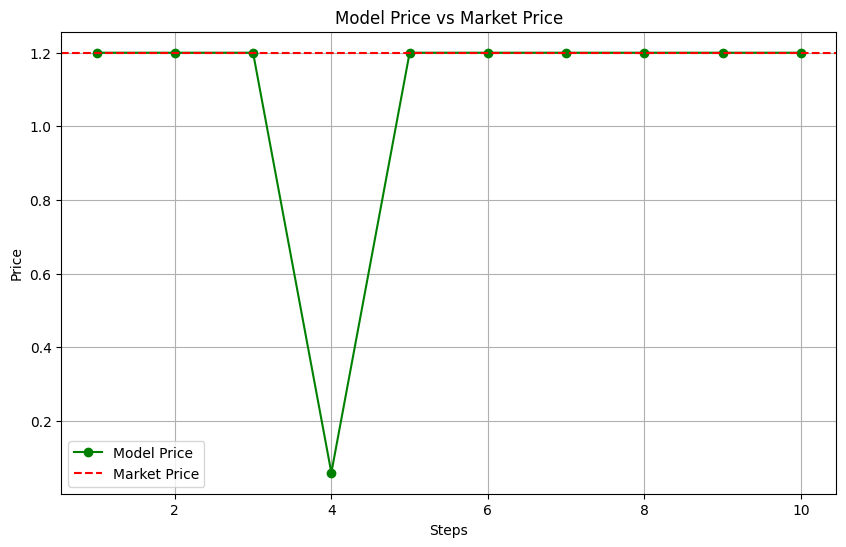

In [10]:
#2. ábra: model price és market price
plt.figure(figsize=(10, 6))
plt.plot(steps_per_year_sizes, model_prices, label="Model Price", color='g', marker='o')
plt.axhline(y=market_price, color='r', linestyle='--', label="Market Price")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.title("Model Price vs Market Price")
plt.legend()
plt.grid(True)
plt.show()

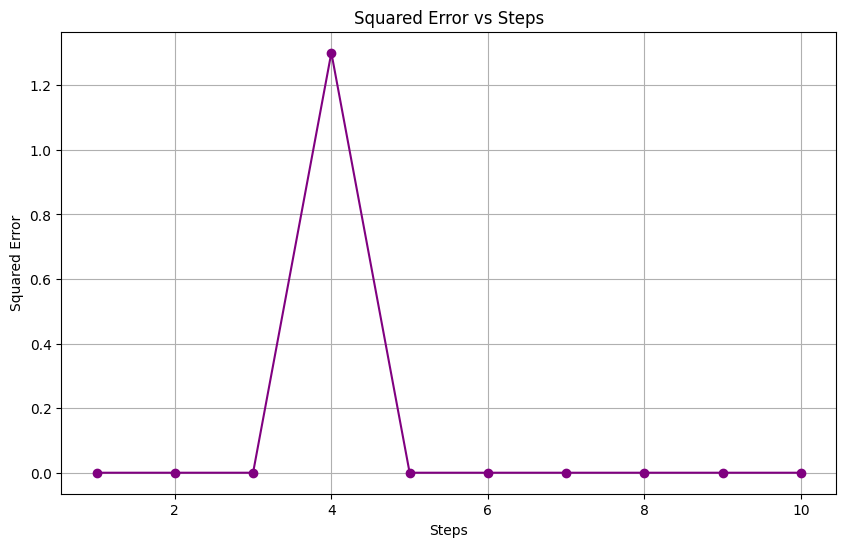

In [11]:
#3. ábra: becslési (négyzetes) hiba
plt.figure(figsize=(10, 6))
plt.plot(steps_per_year_sizes, errors, label="Squared Error", color='purple', marker='o')
plt.xlabel("Steps")
plt.ylabel("Squared Error")
plt.title("Squared Error vs Steps")
plt.grid(True)
plt.show()

##### Different contracts with same number of steps

In [12]:
np.random.seed(107)

# különböző kötési árfolyamok

# paraméterek
spot = 1
disc_factor = 0.95
steps = 3
maturity = 1
market_price = 1.05
strike_prices = np.arange(0.5, 2, 0.1)

spot_mult_up_values = []
spot_mult_down_values = []
model_prices = []
errors = []

for K in strike_prices:
    result = calibrate_tree(spot, K, disc_factor, maturity, steps, market_price)
    if result is not None and result[0] is not None:
        spot_mult_up_values.append(result[0])
        spot_mult_down_values.append(result[1])
        model_prices.append(result[2])
        errors.append(result[3])

Optimal Spot Multiplier Up: 1.0000001
Spot Multiplier Down: 1.034489436382202
Final Model Price: 0.5249999999999999
Squared Error: 0.2756250000000001
Optimal Spot Multiplier Up: 2.113600701673666
Spot Multiplier Down: -0.07911116529146422
Final Model Price: 1.0499999886085472
Squared Error: 1.2976519899257873e-16
Optimal Spot Multiplier Up: 2.1210361318986886
Spot Multiplier Down: -0.08654659551648658
Final Model Price: 1.0499999928122625
Squared Error: 5.166357060308089e-17
Optimal Spot Multiplier Up: 2.1284197964503484
Spot Multiplier Down: -0.09393026006814642
Final Model Price: 1.0500000014902469
Squared Error: 2.220835569138454e-18
Optimal Spot Multiplier Up: 2.1357525593279667
Spot Multiplier Down: -0.10126302294576472
Final Model Price: 1.0499999695928361
Squared Error: 9.245956163140767e-16
Optimal Spot Multiplier Up: 2.1430353394787405
Spot Multiplier Down: -0.1085458030965385
Final Model Price: 1.0499999805407458
Squared Error: 3.7866257433107697e-16
Optimal Spot Multiplier U

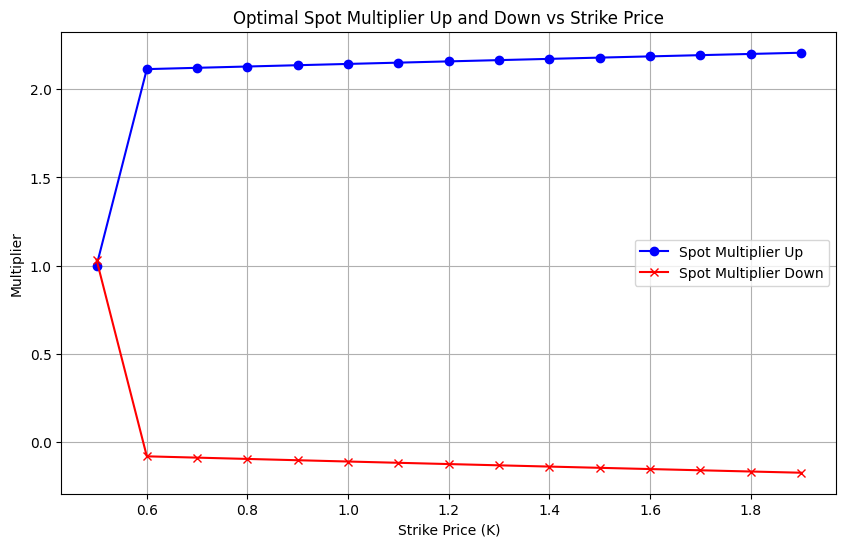

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, spot_mult_up_values, label="Spot Multiplier Up", color='b', marker='o')
plt.plot(strike_prices, spot_mult_down_values, label="Spot Multiplier Down", color='r', marker='x')
plt.xlabel("Strike Price (K)")
plt.ylabel("Multiplier")
plt.title("Optimal Spot Multiplier Up and Down vs Strike Price")
plt.legend()
plt.grid(True)
plt.show()

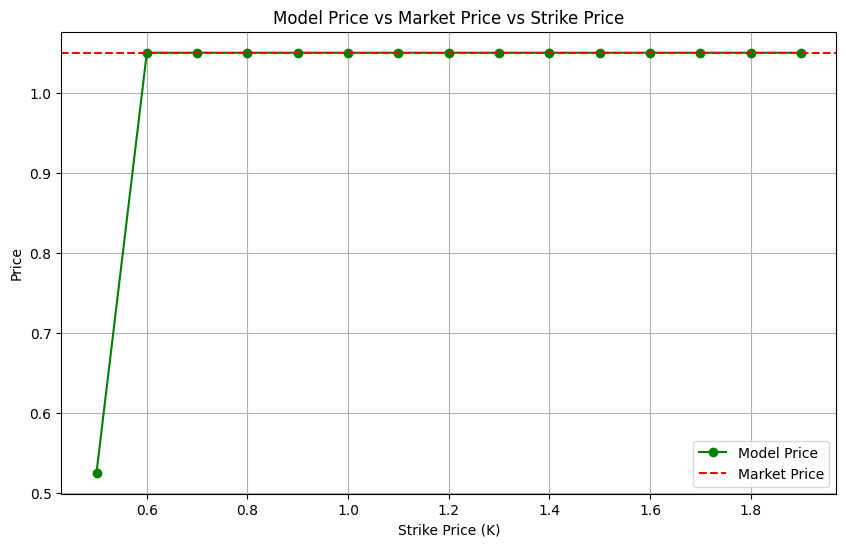

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, model_prices, label="Model Price", color='g', marker='o')
plt.axhline(y=market_price, color='r', linestyle='--', label="Market Price")
plt.xlabel("Strike Price (K)")
plt.ylabel("Price")
plt.title("Model Price vs Market Price vs Strike Price")
plt.legend()
plt.grid(True)
plt.show()

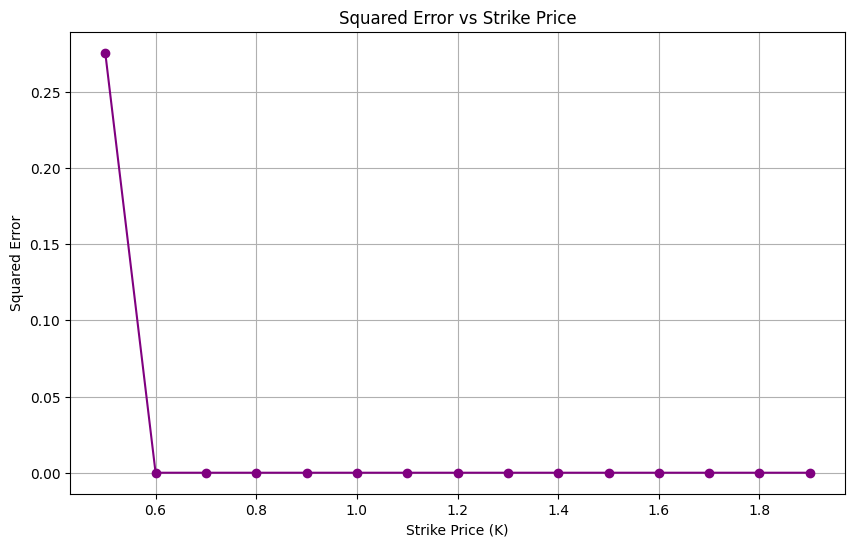

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, errors, label="Squared Error", color='purple', marker='o')
plt.xlabel("Strike Price (K)")
plt.ylabel("Squared Error")
plt.title("Squared Error vs Strike Price")
plt.grid(True)
plt.show()

In [16]:
np.random.seed(101)

# különböző lejárati dátumok

# paraméterek
spot = 1
disc_factor = 0.95
steps = 3
maturity =  np.arange(1,11,1)
market_price = 1.05
K = 1.25

spot_mult_up_values = []
spot_mult_down_values = []
model_prices = []
errors = []

for T in maturity:
    result = calibrate_tree(spot, K, disc_factor, T, steps, market_price)
    if result is not None and result[0] is not None:
        spot_mult_up_values.append(result[0])
        spot_mult_down_values.append(result[1])
        model_prices.append(result[2])
        errors.append(result[3])

Optimal Spot Multiplier Up: 2.1610276262274626
Spot Multiplier Down: -0.1265380898452606
Final Model Price: 1.049997750838109
Squared Error: 5.058729211723414e-12
Optimal Spot Multiplier Up: 2.056799921474394
Spot Multiplier Down: -0.022310385092191964
Final Model Price: 1.0499999742890935
Squared Error: 6.610507138195109e-16
Optimal Spot Multiplier Up: 2.0460014064300127
Spot Multiplier Down: -0.011511870047810735
Final Model Price: 1.049999981068525
Squared Error: 3.5840074773058003e-16
Optimal Spot Multiplier Up: 2.0428185888617643
Spot Multiplier Down: -0.008329052479562282
Final Model Price: 1.0499999726046867
Squared Error: 7.505031936084626e-16
Optimal Spot Multiplier Up: 2.0411216703543533
Spot Multiplier Down: -0.006632133972151344
Final Model Price: 1.0499999700421807
Squared Error: 8.974709393891398e-16
Optimal Spot Multiplier Up: 2.039945889206276
Spot Multiplier Down: -0.005456352824074084
Final Model Price: 1.04999995176542
Squared Error: 2.3265747181787653e-15
Optimal Sp

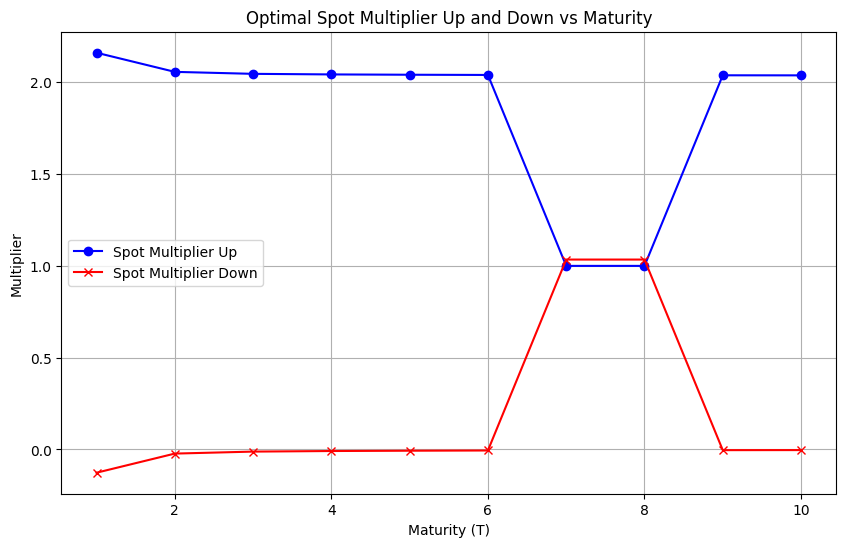

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(maturity, spot_mult_up_values, label="Spot Multiplier Up", color='b', marker='o')
plt.plot(maturity, spot_mult_down_values, label="Spot Multiplier Down", color='r', marker='x')
plt.xlabel("Maturity (T)")
plt.ylabel("Multiplier")
plt.title("Optimal Spot Multiplier Up and Down vs Maturity")
plt.legend()
plt.grid(True)
plt.show()

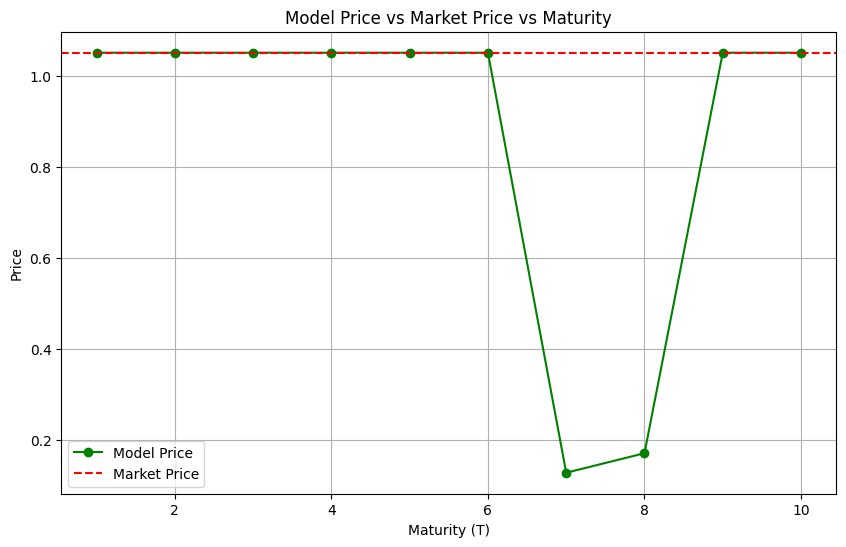

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(maturity, model_prices, label="Model Price", color='g', marker='o')
plt.axhline(y=market_price, color='r', linestyle='--', label="Market Price")
plt.xlabel("Maturity (T)")
plt.ylabel("Price")
plt.title("Model Price vs Market Price vs Maturity")
plt.legend()
plt.grid(True)
plt.show()

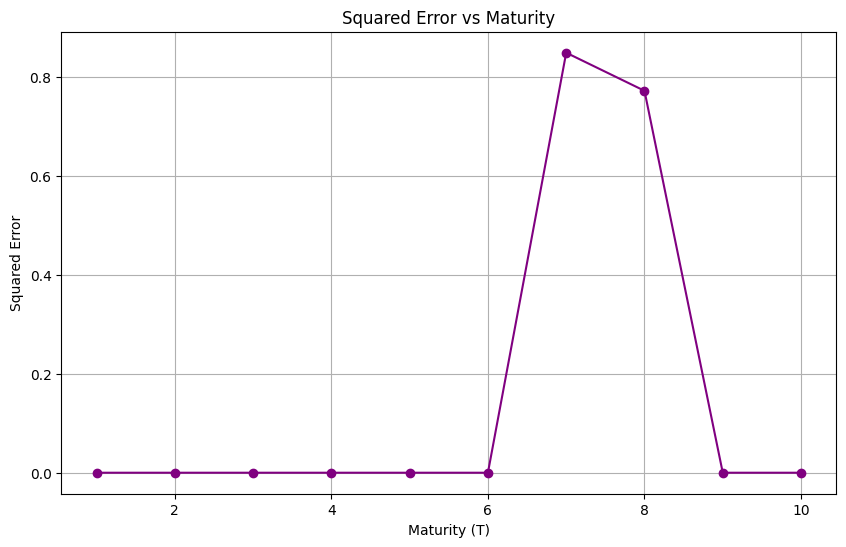

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(maturity, errors, label="Squared Error", color='purple', marker='o')
plt.xlabel("Maturity (T)")
plt.ylabel("Squared Error")
plt.title("Squared Error vs Maturity")
plt.grid(True)
plt.show()